In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
import datetime
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # Mac
matplotlib.rcParams['font.size'] = 15  # 글자크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시 마이너스 꺠지지않게 해줌

In [2]:
df = pd.read_csv('df_final_0627.csv')
df

,자치구,계약일,건물면적(㎡),층,KOSPI종가,Fed기준금리,국제유가(Dubai)($/배럴),부동산거래량,국고채5년(평균),국고채10년(평균),...,CD91물(평균),BOK기준금리,건물연식,GDP대비가계부채비율,환율종가,금값종가,선행지수순환변동치,EPU,장단기금리spread,물건금액(만원)
0,노원구,2016-01-01,39.96,10,1961.310059,0.34,26.9,9894,1.77,2.03,...,1.67,1.50,25,83.3,1175.45,76.81,99.6,177.148845,0.14,18000
1,성동구,2016-01-01,75.37,10,1961.310059,0.34,26.9,9894,1.77,2.03,...,1.67,1.50,26,83.3,1175.45,76.81,99.6,177.148845,0.14,55200
2,금천구,2016-01-01,84.83,3,1961.310059,0.34,26.9,9894,1.77,2.03,...,1.67,1.50,14,83.3,1175.45,76.81,99.6,177.148845,0.14,36800
3,은평구,2016-01-01,101.97,9,1961.310059,0.34,26.9,9894,1.77,2.03,...,1.67,1.50,6,83.3,1175.45,76.81,99.6,177.148845,0.14,67600
4,노원구,2016-01-01,84.59,10,1961.310059,0.34,26.9,9894,1.77,2.03,...,1.67,1.50,26,83.3,1175.45,76.81,99.6,177.148845,0.14,30300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536092,서초구,2022-12-31,152.33,9,2236.399902,4.10,77.2,3698,3.59,3.54,...,4.02,3.25,18,105.0,1260.92,76.11,99.1,169.662386,0.39,250000
536093,송파구,2022-12-31,84.71,11,2236.399902,4.10,77.2,3698,3.59,3.54,...,4.02,3.25,34,105.0,1260.92,76.11,99.1,169.662386,0.39,138000
536094,송파구,2022-12-31,84.90,24,2236.399902,4.10,77.2,3698,3.59,3.54,...,4.02,3.25,14,105.0,1260.92,76.11,99.1,169.662386,0.39,172000
536095,양천구,2022-12-31,64.02,5,2236.399902,4.10,77.2,3698,3.59,3.54,...,4.02,3.25,26,105.0,1260.92,76.11,99.1,169.662386,0.39,37000


In [3]:
df = df[['자치구','계약일','건물면적(㎡)', '층', 'Fed기준금리', '부동산거래량', '건물연식', 'GDP대비가계부채비율', '환율종가',
       'EPU', '장단기금리spread','물건금액(만원)']]

In [4]:
# Train : 2016-2020
# Test : 2021-2022

# 시계열
df['계약일'] = pd.to_datetime(df['계약일'])

train_df = df.loc[df['계약일'] < '2021']
test_df = df.loc[df['계약일'] >= '2021']

In [5]:
X_train = train_df.iloc[ :, 2 : -1]  
y_train = train_df.iloc[ :, -1]

In [6]:
scaler = MinMaxScaler()
scaler
X_train = scaler.fit_transform(X_train)
y_train = np.log10(y_train)

In [7]:
# 랜덤 포레스트 회귀 모델 초기화
model = xgb.XGBRegressor(random_state =1)

# 모델 학습
model.fit(X_train, y_train)b

# Test set에 모델 적용 및 예측 평가
X_test = test_df.iloc[ :, 2 : -1]  # target_column은 예측하고자 하는 종속 변수 컬럼명
y_test = test_df.iloc[ :, -1]
X_test_scaled = scaler.transform(X_test)
y_test_scaled = np.log10(y_test)
test_predictions = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test_scaled, test_predictions)
print("Test set MSE:", test_mse)
print("Test set RMSE:", np.sqrt(test_mse))

Test set MSE: 0.026362900124284983


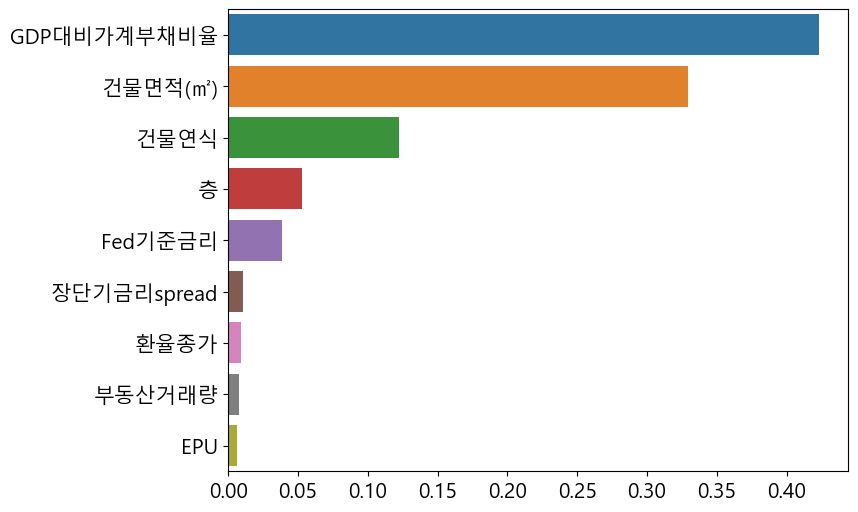

In [8]:
# test_df
importance = model.feature_importances_
# 상위 20개 변수 추출
top_features = pd.Series(importance, index=test_df.iloc[:,2:-1].columns).nlargest(20)
top = top_features.sort_values(ascending=False)[:20]
# 변수 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=top, y=top.index)
plt.show()